<a href="https://colab.research.google.com/github/jinzus/miscellaneous/blob/main/IMPROVING_A_LINEAR_CLASSIFIER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After having seen Steve Brunton's lecture about large image compression with SVD, I decided to create a classifier on the reduced data embedding. Even if Fashion Mnist is definitely not large image size, I don't have other datasets that satisfy the "alignment" condition (at least approximately, here the items are located in the middle of the image). It turns out that in my case the embedding has a little bit of class overlapping, and I'll show you how to improve even a simple linear classifier in this situation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
%matplotlib inline

In [2]:
(_,_),(X,y)=fashion_mnist.load_data()
X=X.reshape(len(X),-1)

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
# Create a function that samples all items of two given class of products and split them in a "training" and "testing" set

def data_builder(data,target,dress):
  Dress_1=data[dress[0]==target]
  Dress_2=data[dress[1]==target]
  train=.3
  D1_train=Dress_1[:int(len(Dress_1)*train)]
  D1_test=Dress_1[len(D1_train):]
  D2_train=Dress_2[:int(len(Dress_2)*train)]
  D2_test=Dress_2[len(D2_train):]
  return D1_train,D2_train,D1_test,D2_test

Item1=0   # t-shirt
Item2=5   # sandal
Data=data_builder(X,y,[0,5])

X_train=np.concatenate((Data[0],Data[1]),axis=0).T
X_test=np.concatenate((Data[2],Data[3]),axis=0).T

# I know that a production-oriented algorithm would be trained on a train set larger than the test one, but since the application of "eigenfaces"
# is made for high-dimensional data (number of pixels larger than number of images), in this way we replicate the result on a much smaller size
# I'll keep this "small train size" also for the following classification and clustering tasks for coherence
X_train.shape

(784, 600)

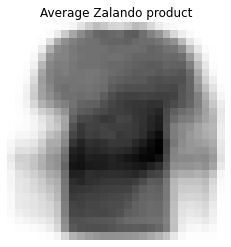

In [4]:
# Perfom the mean fashion products

avgProd=X_train.mean(axis=-1)
plt.imshow(avgProd.reshape(28,28),cmap="binary")
plt.axis('off')
plt.title("Average Zalando product",fontsize=12)

# It looks like a mixture/overlap between a sandal and a t-shirt

X_train_MC=X_train-avgProd[:,np.newaxis]
U,S,V_t=np.linalg.svd(X_train,full_matrices=False)



Text(0.5, 1.0, 'Train set embedding')

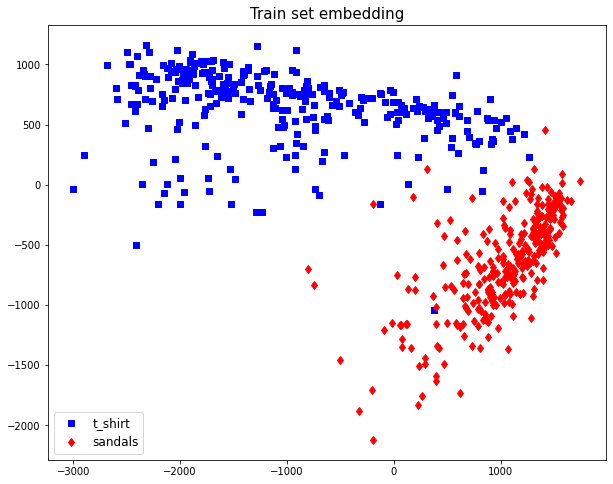

In [5]:
# Take the second and third mode (columns of U) and project down the training data

D1_train=Data[0].T-avgProd[:,np.newaxis]
D2_train=Data[1].T-avgProd[:,np.newaxis]

PCAD1_train=U[:,:2].T@D1_train
PCAD2_train=U[:,:2].T@D2_train

plt.figure(figsize=(10,8))
plt.plot(PCAD1_train[0,:],PCAD1_train[1,:],"bs",label="t_shirt")
plt.plot(PCAD2_train[0,:],PCAD2_train[1,:],"rd",label="sandals")
plt.legend(loc="lower left",fontsize=12)
plt.title("Train set embedding",fontsize=15)


Text(0.5, 1.0, 'Test set embedding')

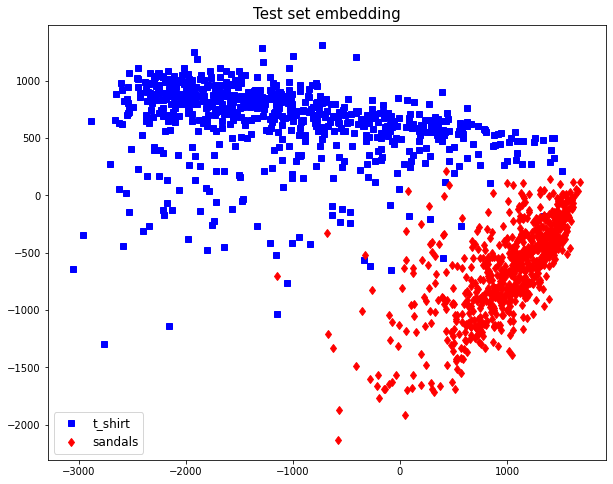

In [6]:
# Project down the test set

D1_test=Data[2].T-avgProd[:,np.newaxis]
D2_test=Data[3].T-avgProd[:,np.newaxis]

PCAD1_test=U[:,:2].T@D1_test
PCAD2_test=U[:,:2].T@D2_test

plt.figure(figsize=(10,8))
plt.plot(PCAD1_test[0,:],PCAD1_test[1,:],"bs",label="t_shirt")
plt.plot(PCAD2_test[0,:],PCAD2_test[1,:],"rd",label="sandals")
plt.legend(loc="lower left",fontsize=12)
plt.title("Test set embedding",fontsize=15)

In [7]:
def data_shuffler(data1,data2):
  target_1=np.zeros(len(data1))
  target_2=np.ones(len(data2))
  features=np.concatenate((data1,data2),axis=0)
  targets=np.concatenate((target_1,target_2))[:,np.newaxis]
  data=np.concatenate((features,targets),axis=-1)
  data=np.random.permutation(data)
  return data

np.random.seed(12)
Dataset_train=data_shuffler(PCAD1_train.T,PCAD2_train.T)
scaler1=StandardScaler()
train_features=scaler1.fit_transform(Dataset_train[:,:2])
svm_cl1=LinearSVC(C=1,loss="hinge",random_state=24)
svm_cl1.fit(train_features,Dataset_train[:,-1])

Dataset_test=data_shuffler(PCAD1_test.T,PCAD2_test.T)
test_features=scaler1.transform(Dataset_test[:,:2])
preds=svm_cl1.predict(test_features)
print("Confusion matrix for test set:","\n",confusion_matrix(Dataset_test[:,-1],preds))


Confusion matrix for test set: 
 [[687  13]
 [  5 695]]


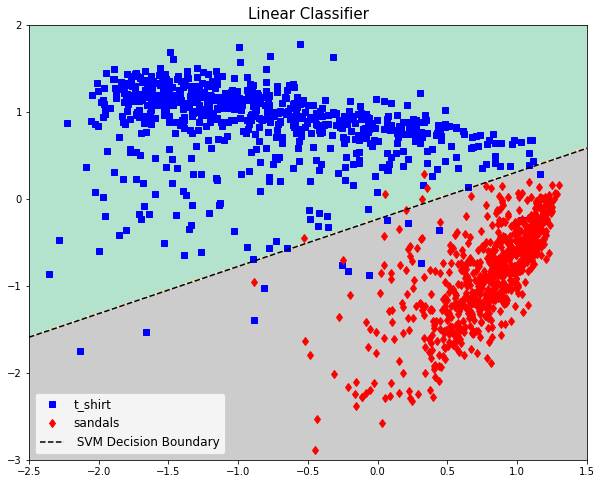

In [8]:
# Plot the decision boundary and test set 

x0, x1 = np.meshgrid(np.linspace(-2.5, 1.5, 500).reshape(-1, 1),np.linspace(-3,2, 200).reshape(-1, 1),)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = svm_cl1.predict(X_new)
Y_pr=y_predict.reshape(x0.shape)
plt.figure(figsize=(10,8))
plt.plot(test_features[:,0][Dataset_test[:,-1]==0],test_features[:,1][Dataset_test[:,-1]==0],"bs",label="t_shirt")
plt.plot(test_features[:,0][Dataset_test[:,-1]==1],test_features[:,1][Dataset_test[:,-1]==1],"rd",label="sandals")
plt.contourf(x0,x1,Y_pr,cmap=plt.cm.Pastel2)
angs=np.linspace(-2.5,1.5,200)
boundary=-(svm_cl1.coef_[0][0]*angs+svm_cl1.intercept_[0])/svm_cl1.coef_[0][1]
plt.plot(angs,boundary,"k--",label=" SVM Decision Boundary")
plt.title("Linear Classifier",fontsize=15)
plt.axis([-2.5,1.5,-3,2])
plt.legend(loc="lower left",fontsize=12)


Even a more complex non-linear model would probablty struggle in improving this
linear one, because there is a lot of overlapping between the instances of the
two classes. A possible solution could be to use a density-based clustering
algorithm (trained on the small training set in the same fashion as before) in order to clean anomaly data  entries, and then using a linear  classifier that works only on those instances that are not anomalies according to the clustering algorithm

Text(0.5, 1.0, 'Normalities in cluster 1 and in cluster 2')

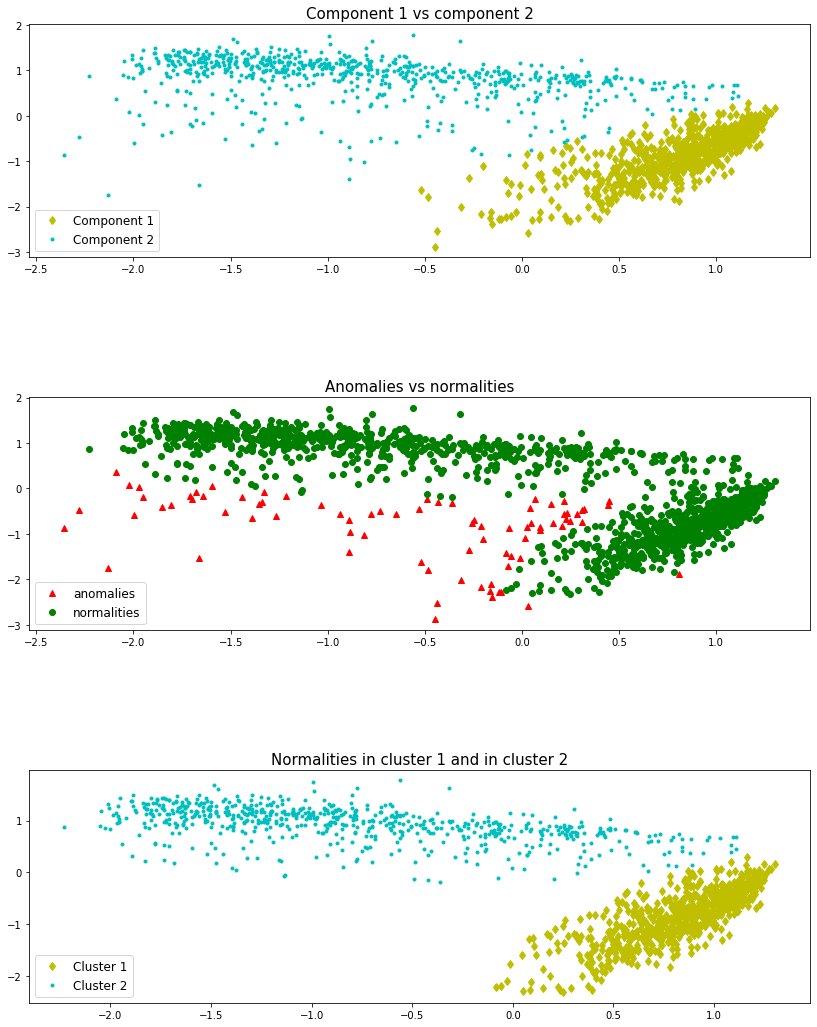

In [9]:
# Anomaly detection

gmm=GaussianMixture(n_components=2,n_init=10,random_state=56)
gmm.fit(train_features) 
train_densities=gmm.score_samples(train_features)
test_densities=gmm.score_samples(test_features)
threshold=np.percentile(train_densities,5)     # thresholding to 5%, these are the "defective" instances
anomalies_train=train_features[train_densities<threshold]    # anomaly if log_proba<treshold
normalities_train=train_features[train_densities>threshold]
anomalies_test=test_features[test_densities<threshold]   
normalities_test=test_features[test_densities>threshold]
test_clustering=gmm.predict(test_features)

# cluster assignments 
cl_anomalies=gmm.predict(anomalies_test)
cl_normalities=gmm.predict(normalities_test)

# labels for the two groups
y_anomalies_train=Dataset_train[train_densities<threshold,-1] 
y_normalities_train=Dataset_train[train_densities>threshold,-1] 
y_anomalies_test=Dataset_test[test_densities<threshold,-1] 
y_normalities_test=Dataset_test[test_densities>threshold,-1] 

plt.figure(figsize=(14,18))
plt.subplots_adjust(wspace=0.8,hspace=0.6)
plt.subplot(311)
plt.plot(test_features[:,0][test_clustering==0],test_features[:,1][test_clustering==0],"yd",label="Component 1")
plt.plot(test_features[:,0][test_clustering==1],test_features[:,1][test_clustering==1],"c.",label="Component 2")
plt.legend(loc="lower left",fontsize=12)
plt.title("Component 1 vs component 2",fontsize=15)

plt.subplot(312)
plt.plot(anomalies_test[:,0],anomalies_test[:,1],"r^",label="anomalies")
plt.plot(normalities_test[:,0],normalities_test[:,1],"go",label="normalities")
plt.legend(loc="lower left",fontsize=12)
plt.title("Anomalies vs normalities",fontsize=15)

plt.subplot(313)
plt.plot(test_features[(test_densities>threshold)&(test_clustering==0)][:,0],test_features[(test_densities>threshold)&(test_clustering==0)][:,1],"yd",label="Cluster 1")
plt.plot(test_features[(test_densities>threshold)&(test_clustering==1)][:,0],test_features[(test_densities>threshold)&(test_clustering==1)][:,1],"c.",label="Cluster 2")
plt.legend(loc="lower left",fontsize=12)
plt.title("Normalities in cluster 1 and in cluster 2",fontsize=15)


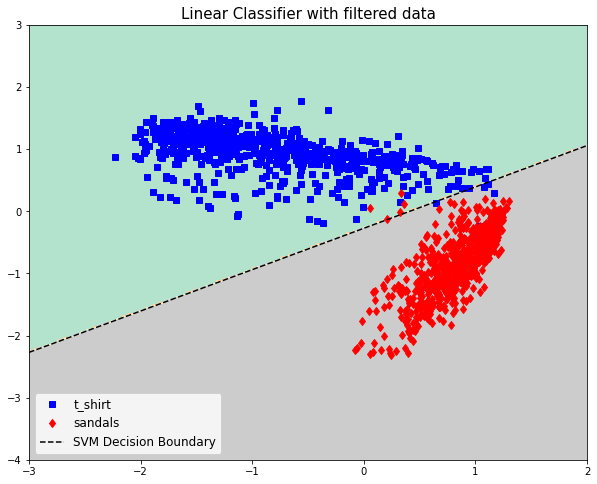

In [10]:
# Let's train the predictor on the non_anomalies of the training set and then plot with non_anomalies of test set

svm_cl2=LinearSVC(C=.1,loss="hinge",random_state=24)
svm_cl2.fit(normalities_train,y_normalities_train)
preds_=svm_cl2.predict(normalities_test)

x0, x1 = np.meshgrid(np.linspace(-3, 2, 500).reshape(-1, 1),np.linspace(-4, 3, 200).reshape(-1, 1),)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = svm_cl2.predict(X_new)
Y_pr=y_predict.reshape(x0.shape)
plt.figure(figsize=(10,8))
plt.plot(normalities_test[:,0][y_normalities_test==0],normalities_test[:,1][y_normalities_test==0],"bs",label="t_shirt")
plt.plot(normalities_test[:,0][y_normalities_test==1],normalities_test[:,1][y_normalities_test==1],"rd",label="sandals")
plt.contourf(x0,x1,Y_pr,cmap=plt.cm.Pastel2)
angs=np.linspace(-3,2,200)
boundary=-(svm_cl2.coef_[0][0]*angs+svm_cl2.intercept_[0])/svm_cl2.coef_[0][1]
plt.plot(angs,boundary,"k--",label="SVM Decision Boundary")
plt.axis([-3,2,-4,3])
plt.title("Linear Classifier with filtered data",fontsize=15)
plt.legend(loc="lower left",fontsize=12)


In [11]:
# The evident downside of this solution is that during classification it simply ignores some instances as "defective"...
# ...on the other hand, the cleaned dataset seems to improve the confusion matrix 

print("Confusion matrix for cleaned test set:","\n",confusion_matrix(y_normalities_test,preds_))

Confusion matrix for cleaned test set: 
 [[653   5]
 [  5 656]]


Number of class 0 instances full set 700
Number of class 1 instances full set 700
Number of class 0 instances cleaned set 658
Number of class 1 instances cleaned set 661


Text(0.5, 1.0, 'Linear clf only vs Clustering+Linear clf')

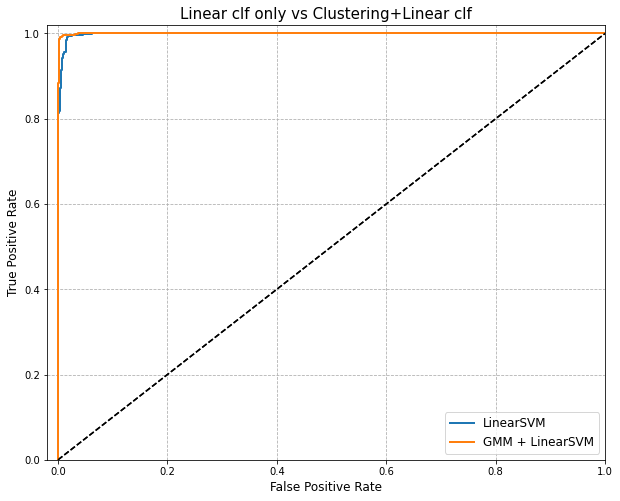

In [12]:
print("Number of class 0 instances full set",len(Dataset_test[Dataset_test[:,-1]==0]))
print("Number of class 1 instances full set",len(Dataset_test[Dataset_test[:,-1]==1]))
print("Number of class 0 instances cleaned set",len(y_normalities_test[y_normalities_test==0]))
print("Number of class 1 instances cleaned set",len(y_normalities_test[y_normalities_test==1]))
# Since the dataset is not too skewed in classes for neither of the two cases, ROC is informative

y_scores=svm_cl1.decision_function(test_features)
y_scores_=svm_cl2.decision_function(normalities_test)
fpr, tpr, thresholds = roc_curve(Dataset_test[:,-1],y_scores)
fpr_,tpr_,tresholds_=roc_curve(y_normalities_test,y_scores_)
#
def plot_roc_curve(fpr, tpr,labels):
    plt.plot(fpr, tpr, linewidth=2,label=labels)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([-0.02, 1, 0, 1.02])                                    
    plt.xlabel('False Positive Rate', fontsize=12) 
    plt.ylabel('True Positive Rate', fontsize=12)    
    plt.grid(True,linestyle="--")                                            

plt.figure(figsize=(10,8))                         
plot_roc_curve(fpr, tpr,"LinearSVM")
plot_roc_curve(fpr_,tpr_,"GMM + LinearSVM")
plt.legend(loc="lower right",fontsize=12)
plt.title("Linear clf only vs Clustering+Linear clf",fontsize=15)
